In [1]:
import os as os
import sys as sys
import re as re
import pandas as pd
import numpy as np
import json as json
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pd.options.display.max_columns = 100
pd.options.display.min_rows = None
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 1000

from config import RANDOM_STATE, MATERIALS_PATH, RESULTS_PATH

GENE_SYMBOL_EFFECT_SIZE = MATERIALS_PATH.joinpath('capstone_body_weight_Statistical_effect_size_analysis_genotype_early_adult_scaled_13022023_gene_symbol_harmonized.pkl')
PROTEIN_SEQUENCE_PATH = MATERIALS_PATH.joinpath('gene_symbol_protein_sequences.pkl')
EXON_SEQUENCE_PATH = MATERIALS_PATH.joinpath('gene_symbol_dna_sequence_exon.pkl')
UNSPLICED_SEQUENCE_PATH = MATERIALS_PATH.joinpath('gene_symbol_dna_sequence_unspliced.pkl')

FRAC = 1

42


In [2]:
df = pd.read_pickle(GENE_SYMBOL_EFFECT_SIZE)

df = df.groupby(['gene_symbol_harmonized'])[['est_m_ea']].agg('mean')

df = df.reset_index()

df = df.sample(frac=FRAC, random_state=RANDOM_STATE)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit(df[['est_m_ea']].to_numpy())

df['class'] = kmeans.labels_

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_effect_size = df.copy()

print(df.shape)

(1374, 3)


In [3]:
df = pd.read_pickle(PROTEIN_SEQUENCE_PATH)

df = df.rename({'seq': 'sequence'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

print(df['class'].value_counts())

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_protein = df.copy()

print(df.shape)

0    718
1    540
2     94
Name: class, dtype: int64
(1352, 4)


In [4]:
df = pd.read_pickle(EXON_SEQUENCE_PATH)

df = df.rename({'Sequence': 'sequence', 'Gene name': 'gene_symbol_harmonized'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

print(df['class'].value_counts())

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_exon = df.copy()

print(df.shape)

0    728
1    546
2     95
Name: class, dtype: int64
(1369, 4)


In [5]:
df = pd.read_pickle(UNSPLICED_SEQUENCE_PATH)

df = df.rename({'Sequence': 'sequence', 'Gene name': 'gene_symbol_harmonized'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

print(df['class'].value_counts())

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_unspliced = df.copy()

print(df.shape)

0    728
1    546
2     95
Name: class, dtype: int64
(1369, 4)


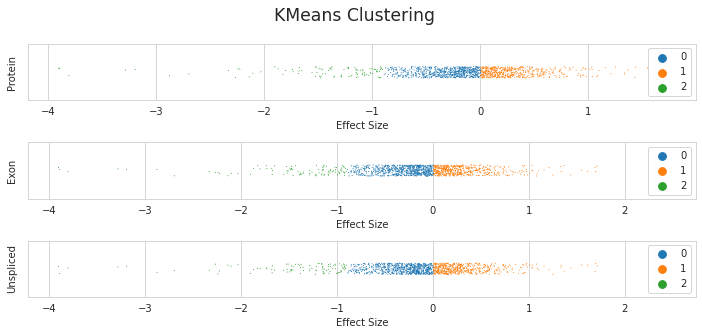

In [6]:
df = _df_protein.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Protein'] = ''

_df_protein_strip_plot = df.copy()



df = _df_exon.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Exon'] = ''

_df_exon_strip_plot = df.copy()



df = _df_unspliced.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Unspliced'] = ''

_df_unspliced_strip_plot = df.copy()



sns.set_style('whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

fig.suptitle('KMeans Clustering', fontsize='xx-large')
fig.set_size_inches((10,4.5))
fig.tight_layout()

_ = sns.stripplot(data=_df_protein_strip_plot, x='Effect Size', y='Protein', hue="Class", marker='.', jitter=True, s=2, ax=ax1, palette='tab10')
_= ax1.legend(loc='right')
_ = sns.stripplot(data=_df_exon_strip_plot, x='Effect Size', y='Exon', hue="Class", marker='.', jitter=True, s=2,  ax=ax2, palette='tab10')
_= ax2.legend(loc='right')
_ = sns.stripplot(data=_df_unspliced_strip_plot, x='Effect Size', y='Unspliced', hue="Class", marker='.', jitter=True, s=2,  ax=ax3, palette='tab10')
_= ax3.legend(loc='right')

plt.subplots_adjust(wspace=0.3, hspace=0.75)
plt.savefig(RESULTS_PATH.joinpath(f'kmeans_clustering_{FRAC}_{RANDOM_STATE}.png'), bbox_inches='tight')

In [7]:
def feature_density(df, ngram_range):

    tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=ngram_range)

    X = tfidf.fit_transform(df['sequence'].tolist())

    X = X.todense()

    df = pd.DataFrame(X, columns=tfidf.get_feature_names_out())

    df = df.T.copy()

    kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit(df.to_numpy())

    df['Class'] = kmeans.labels_

    print(pd.Series(kmeans.labels_).value_counts())

    df = df.groupby(['Class']).apply(lambda x: ((x != 0).sum().sum()/(x.shape[0] * x.shape[1]), x.index.tolist())).to_frame(name='density_features').reset_index()

    df['Density'] = df.apply(lambda x: x['density_features'][0], axis=1)

    df['Features'] = df.apply(lambda x: x['density_features'][1], axis=1)

    df['Count'] = df['Features'].apply(lambda x: len(x))

    df = df.drop(['density_features'], axis=1)

    return df.copy()

In [8]:
_df_protein_features = feature_density(df=_df_protein.copy(), ngram_range=(4,4))

1    123367
2     20840
0       101
dtype: int64


In [9]:
_df_exon_features = feature_density(df=_df_exon.copy(), ngram_range=(10,10))

2    752775
1    206435
0      4556
dtype: int64


In [10]:
_df_unspliced_features = feature_density(df=_df_unspliced.sample(frac=.1, random_state=RANDOM_STATE).copy(), ngram_range=(12,12))

1    4631455
0      77959
2          9
dtype: int64


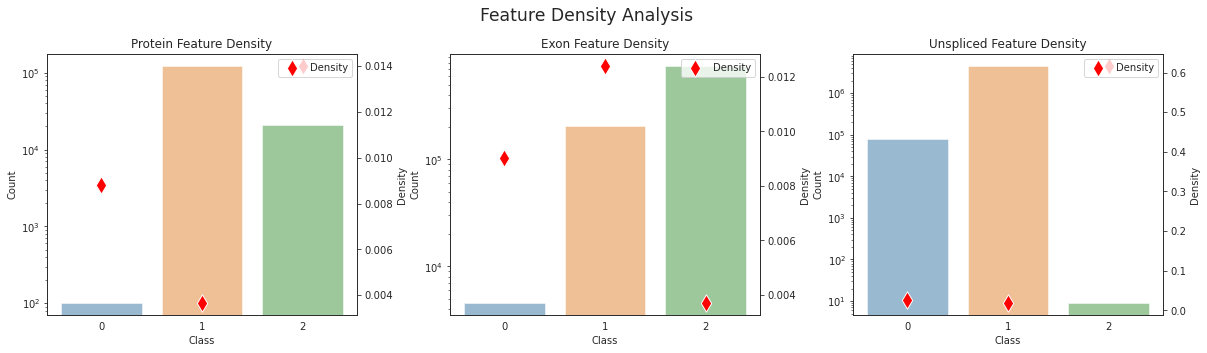

In [11]:
sns.set_style('white')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.suptitle('Feature Density Analysis', fontsize='xx-large')
fig.set_size_inches((20,5))
fig.subplots_adjust(top=.85)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

sns.barplot(data=_df_protein_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax1, palette='tab10')
ax1.set_yscale("log")
ax1.set_title('Protein Feature Density')
ax1_twin = ax1.twinx()
sns.scatterplot(data=_df_protein_features, x='Class', y='Density', marker='d', label='Density', color = 'red', s=150, ax=ax1_twin, palette='tab10')
_= ax1_twin.legend(loc='upper right')

sns.barplot(data=_df_exon_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax2, palette='tab10')
ax2.set_yscale("log")
ax2.set_title('Exon Feature Density')
ax2_twin = ax2.twinx()
sns.scatterplot(data=_df_exon_features, x='Class', y='Density', marker='d', label='Density', color = 'red', s=150, ax=ax2_twin, palette='tab10')
_= ax2_twin.legend(loc='upper right')

sns.barplot(data=_df_unspliced_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax3, palette='tab10')
ax3.set_yscale("log")
ax3.set_title('Unspliced Feature Density')
ax3_twin = ax3.twinx()
sns.scatterplot(data=_df_unspliced_features, x='Class', y='Density', marker='d', label='Density', color = 'red', s=150, ax=ax3_twin, palette='tab10')
_= ax3_twin.legend(loc='upper right')

plt.savefig(RESULTS_PATH.joinpath(f'feature_density_analysis_{FRAC}_{RANDOM_STATE}.png'), bbox_inches='tight')

In [12]:
def train_tfidf_smote_estimator_grid(est_grid, X_train, y_train, analyzer, vocabulary, random_state=RANDOM_STATE):

    estimator_model = {}

    for est, param_grid in est_grid.items():
        
        pipeline = Pipeline(steps=[
            ('TfidfVectorizer', TfidfVectorizer(analyzer='char_wb', vocabulary=vocabulary)),
            ('SMOTE', SMOTE(random_state=RANDOM_STATE)),
            (est.__class__.__name__, est)
        ])

        model = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=5, verbose=4)

        model.fit(X_train, y_train)

        estimator_model[est] = model

    return estimator_model
        

In [13]:
df = _df_protein_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

protein_vocabulary = df['Features'].sum()

df = _df_protein.copy()

X = df['sequence'].to_numpy()

y = df['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE)

ngram_range = (4,4)

est_grid = {
    KNeighborsClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'KNeighborsClassifier__n_neighbors': [3, 5, 9]
    },
    LogisticRegression(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    SVC(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'SVC__kernel': ['linear', 'rbf'],
        'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'SVC__gamma': ['scale', 'auto']
    },
    DummyClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range':[ngram_range],
        'DummyClassifier__strategy': ['most_frequent']
    },
    DummyClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'DummyClassifier__strategy': ['uniform']
    }
}

estimator_model = train_tfidf_smote_estimator_grid(est_grid=est_grid, X_train=X_train, y_train=y_train, analyzer='char_wb', vocabulary=protein_vocabulary)

with open(RESULTS_PATH.joinpath(f'protein_{FRAC}_{RANDOM_STATE}.pkl'), 'wb') as f:
    pickle.dump({
        'RANDOM_STATE': RANDOM_STATE,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'estimator_model': estimator_model
    }, f)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 2/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.398 total time=   1.5s
[CV 3/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.403 total time=   1.2s
[CV 1/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.392 total time=   1.8s
[CV 4/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.394 total time=   1.3s
[CV 5/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.477 total time=   1.4s
[CV 1/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.166 total time=   0.8s
[CV 2/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngr

/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.475 total time=   5.8s
[CV 5/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.472 total time=   8.9s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.532 total time=   8.1s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 3/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.454 total time=   8.3s
[CV 4/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.463 total time=   8.0s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.426 total time=  10.4s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.493 total time=  10.5s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.537 total time=   8.9s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.505 total time=   9.3s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.458 total time=   9.7s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.486 total time=   6.0s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.470 total time=   6.0s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.472 total time=   5.1s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 2/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.537 total time=   7.0s
[CV 3/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.449 total time=   6.3s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.421 total time=   6.3s


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 2/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.398 total time=  23.2s
[CV 1/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.401 total time=  26.6s
[CV 4/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.532 total time=  26.6s
[CV 5/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.440 total time=  26.8s
[CV 3/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l1;, score=0.394 total time=  28.2s
[CV 1/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(4, 4), TfidfVectorizer__norm=l2;, score=0.5

In [14]:
df = _df_exon_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

exon_vocabulary = df['Features'].sum()

df = _df_exon.copy()

X = df['sequence'].to_numpy()

y = df['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE)

ngram_range = (10,10)

est_grid = {
    KNeighborsClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'KNeighborsClassifier__n_neighbors': [3, 5, 9]
    },
    LogisticRegression(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    SVC(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'SVC__kernel': ['linear', 'rbf'],
        'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'SVC__gamma': ['scale', 'auto']
    },
    DummyClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range':[ngram_range],
        'DummyClassifier__strategy': ['most_frequent']
    },
    DummyClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'DummyClassifier__strategy': ['uniform']
    }
}

estimator_model = train_tfidf_smote_estimator_grid(est_grid=est_grid, X_train=X_train, y_train=y_train, analyzer='char_wb', vocabulary=exon_vocabulary)

with open(RESULTS_PATH.joinpath(f'exon_{FRAC}_{RANDOM_STATE}.pkl'), 'wb') as f:
    pickle.dump({
        'RANDOM_STATE': RANDOM_STATE,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'estimator_model': estimator_model
    }, f)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 3/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.078 total time=  11.6s
[CV 4/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.078 total time=  11.5s
[CV 2/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.078 total time=  12.6s
[CV 1/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.073 total time=  13.3s
[CV 5/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.393 total time=  13.0s
[CV 2/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.119 total time=  15.0s
[CV 4/5] END KNeighborsClassifier__n_neighbors=3, TfidfVec

/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.525 total time= 1.3min
[CV 2/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.502 total time= 1.3min
[CV 4/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.502 total time= 1.2min
[CV 3/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.511 total time= 1.2min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.507 total time= 1.4min
[CV 1/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.539 total time=  46.1s
[CV 2/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.493 total time=  42.7s
[CV 3/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.507 total time=  55.1s
[CV 5/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.525 total time=  44.1s
[CV 4/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.525 total time= 1.1min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.525 total time= 1.2min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.502 total time= 1.3min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.507 total time= 1.3min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 5/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.511 total time= 1.2min
[CV 4/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l2;, score=0.493 total time= 1.3min
Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 5/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.393 total time= 3.0min
[CV 4/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.521 total time= 3.3min
[CV 1/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.397 total time= 3.5min
[CV 2/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(10, 10), TfidfVectorizer__norm=l1;, score=0.388 total time= 3.6min
[CV 3/5] END S

In [15]:
df = _df_unspliced_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

unspliced_vocabulary = df['Features'].sum()

df = _df_unspliced.copy()

X = df['sequence'].to_numpy()

y = df['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE)

ngram_range = (12,12)

est_grid = {
    KNeighborsClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'KNeighborsClassifier__n_neighbors': [3, 5, 9]
    },
    LogisticRegression(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    SVC(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'SVC__kernel': ['linear', 'rbf'],
        'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'SVC__gamma': ['scale', 'auto']
    },
    DummyClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range':[ngram_range],
        'DummyClassifier__strategy': ['most_frequent']
    },
    DummyClassifier(): {
        'TfidfVectorizer__norm': ('l1', 'l2'),
        'TfidfVectorizer__ngram_range': [ngram_range],
        'DummyClassifier__strategy': ['uniform']
    }
}

estimator_model = train_tfidf_smote_estimator_grid(est_grid=est_grid, X_train=X_train, y_train=y_train, analyzer='char_wb', vocabulary=unspliced_vocabulary)

with open(RESULTS_PATH.joinpath(f'unspliced_{FRAC}_{RANDOM_STATE}.pkl'), 'wb') as f:
    pickle.dump({
        'RANDOM_STATE': RANDOM_STATE,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'estimator_model': estimator_model
    }, f)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.338 total time= 1.5min
[CV 1/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.306 total time= 1.5min
[CV 2/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.260 total time= 1.6min
[CV 3/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.283 total time= 1.6min
[CV 5/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.306 total time= 1.6min
[CV 2/5] END KNeighborsClassifier__n_neighbors=3, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.247 total time= 1.4min
[CV 1/5] END KNeighborsClassifier__n_neighbors=3, TfidfVec

/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 1/5] END LogisticRegression__C=10, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.411 total time= 1.8min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 3/5] END LogisticRegression__C=10, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.447 total time= 1.7min
[CV 2/5] END LogisticRegression__C=10, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.466 total time= 1.8min
[CV 4/5] END LogisticRegression__C=10, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.484 total time= 1.8min
[CV 5/5] END LogisticRegression__C=10, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.457 total time= 1.9min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.434 total time= 1.7min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 2/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.379 total time= 1.9min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.393 total time= 1.9min
[CV 4/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.416 total time= 1.9min
[CV 5/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.384 total time= 1.8min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.416 total time= 1.8min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 2/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.466 total time= 1.8min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.475 total time= 1.8min
[CV 5/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.457 total time= 1.8min
[CV 4/5] END LogisticRegression__C=100, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.489 total time= 1.9min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.447 total time= 1.8min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 2/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.429 total time= 2.0min
[CV 3/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.429 total time= 1.9min
[CV 4/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.461 total time= 1.8min
[CV 5/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.420 total time= 1.9min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.438 total time= 1.7min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

[CV 3/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.466 total time= 1.7min
[CV 2/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.447 total time= 1.8min
[CV 4/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.493 total time= 1.7min
[CV 5/5] END LogisticRegression__C=1000, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2;, score=0.461 total time= 1.7min


/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.137 total time= 2.6min
[CV 5/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.078 total time= 2.6min
[CV 4/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.091 total time= 2.7min
[CV 3/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.078 total time= 2.7min
[CV 2/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l1;, score=0.073 total time= 2.8min
[CV 1/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, TfidfVectorizer__ngram_range=(12, 12), TfidfVectorizer__norm=l2